In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


# Hyperparameters

In [2]:
# Hyper-parameters <==== Changes
latent_size = 64
hidden_size = 256
image_size = 28*28
# Number of steps apply to Discriminator, K
K = 1 
# Fix Hyper-parameters
num_epochs = 100
batch_size = 100

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])
# MNIST dataset
mnist = torchvision.datasets.FashionMNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Construct Class

In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, leaky=0.2):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(image_size, hidden_size),
                                     nn.LeakyReLU(0.2))        
        self.linear2 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.LeakyReLU(0.2))           
        self.linear3 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.LeakyReLU(0.2))           
        self.linear4 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.LeakyReLU(0.2))                  
        self.linear5 = nn.Sequential(nn.Linear(hidden_size, 1),
                                     nn.Sigmoid())          
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(latent_size, hidden_size),
                                     nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.ReLU())
        self.linear3 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.ReLU())
        self.linear4 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                     nn.ReLU())
        self.linear5 = nn.Sequential(nn.Linear(hidden_size, image_size),
                                     nn.Tanh())          
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x

In [5]:
D = Discriminator(image_size, hidden_size, leaky=0.2).to(device)
G = Generator(latent_size, hidden_size, image_size).to(device)
D = D.to(device)
G = G.to(device)

In [6]:
print("Generator Architecture:")
print(G)
print("\n\nDiscriminator Architecture:")
print(D)

Generator Architecture:
Generator(
  (linear1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear4): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear5): Sequential(
    (0): Linear(in_features=256, out_features=784, bias=True)
    (1): Tanh()
  )
)


Discriminator Architecture:
Discriminator(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2

# Set Criterion and Optimizer

In [7]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Training

In [8]:
def denorm(x):
    # TANH (-1, 1)
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [9]:
text_file = open("gan_results.txt", "w")
count_step = 0
count_step_list = []
d_loss_list = []
g_loss_list = []
realscore_list = []
fakescore_list = []

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader): 
        count_step+=1
        # i = number of batches = 60000 number of images / 100 images per batch = 600 batches
        # images = 1 batch which includes 100 images in one batch = 100 images with each size [1x784]
        # _ = labels for each image in one batch = 100 labels 
        images = images.reshape(batch_size, -1).to(device) # batch size x 784
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device) # batch size x 1
        fake_labels = torch.zeros(batch_size, 1).to(device) # batch size x 1

        # =====================Train the discriminator====================== #
        for k_discriminator_steps in range(K):
            ### Train Label = 1 when Images are Real
            outputs = D(images)  # batch size x 1
            d_loss_real = criterion(outputs, real_labels)   # batch size x 1
            real_score = outputs  # batch size x 1
    
            ### Train Label = 0 when Images are Fake
            z = torch.randn(batch_size, latent_size).to(device)   # batch size x 64
            fake_images = G(z)    # batch size x 784
            outputs = D(fake_images)  # batch size x 1
            d_loss_fake = criterion(outputs, fake_labels)  # batch size x 1
            fake_score = outputs  # batch size x 1
        
            ### Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
        
        # =======================Train the generator======================= #
        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            count_step_list.append(count_step)
            d_loss_list.append(d_loss.item())
            g_loss_list.append(g_loss.item())
            realscore_list.append(real_score.mean().item())
            fakescore_list.append(fake_score.mean().item())
            
            print('Epoch [{}/{}], Step [{}/{}]:\nDiscriminator_loss: {:.4f}, Generator_loss: {:.4f}\nReal Score Mean D(x): {:.2f}, Fake Score Mean D(G(z)): {:.2f}\n' 
                  .format(epoch, num_epochs, i+1, total_step,
                          d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            
            text_file.write('Epoch [{}/{}], Step [{}/{}]:\nDiscriminator_loss: {:.4f}, Generator_loss: {:.4f}\nReal Score Mean D(x): {:.2f}, Fake Score Mean D(G(z)): {:.2f}\n' 
                  .format(epoch, num_epochs, i+1, total_step,
                          d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            text_file.write("\n")
        
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    #torch.save(G.state_dict(), 'G.ckpt')
    #torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/100], Step [200/600]:
Discriminator_loss: 0.9760, Generator_loss: 6.2899
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.00

Epoch [0/100], Step [400/600]:
Discriminator_loss: 0.0898, Generator_loss: 5.0001
Real Score Mean D(x): 1.00, Fake Score Mean D(G(z)): 0.08

Epoch [0/100], Step [600/600]:
Discriminator_loss: 0.0776, Generator_loss: 5.4857
Real Score Mean D(x): 0.98, Fake Score Mean D(G(z)): 0.04

Epoch [1/100], Step [200/600]:
Discriminator_loss: 0.2597, Generator_loss: 5.4632
Real Score Mean D(x): 0.94, Fake Score Mean D(G(z)): 0.10

Epoch [1/100], Step [400/600]:
Discriminator_loss: 0.2160, Generator_loss: 6.2213
Real Score Mean D(x): 0.98, Fake Score Mean D(G(z)): 0.13

Epoch [1/100], Step [600/600]:
Discriminator_loss: 0.0386, Generator_loss: 4.3445
Real Score Mean D(x): 1.00, Fake Score Mean D(G(z)): 0.04

Epoch [2/100], Step [200/600]:
Discriminator_loss: 0.4064, Generator_loss: 6.9232
Real Score Mean D(x): 0.89, Fake Score Mean D(G(z)): 0.03

Epoch [2/100]

Epoch [19/100], Step [400/600]:
Discriminator_loss: 0.4459, Generator_loss: 2.4677
Real Score Mean D(x): 0.83, Fake Score Mean D(G(z)): 0.15

Epoch [19/100], Step [600/600]:
Discriminator_loss: 0.5072, Generator_loss: 3.6132
Real Score Mean D(x): 0.85, Fake Score Mean D(G(z)): 0.15

Epoch [20/100], Step [200/600]:
Discriminator_loss: 0.3217, Generator_loss: 4.9880
Real Score Mean D(x): 0.89, Fake Score Mean D(G(z)): 0.06

Epoch [20/100], Step [400/600]:
Discriminator_loss: 0.3056, Generator_loss: 4.8541
Real Score Mean D(x): 0.93, Fake Score Mean D(G(z)): 0.13

Epoch [20/100], Step [600/600]:
Discriminator_loss: 0.4227, Generator_loss: 3.4042
Real Score Mean D(x): 0.90, Fake Score Mean D(G(z)): 0.17

Epoch [21/100], Step [200/600]:
Discriminator_loss: 0.5639, Generator_loss: 3.3327
Real Score Mean D(x): 0.87, Fake Score Mean D(G(z)): 0.15

Epoch [21/100], Step [400/600]:
Discriminator_loss: 0.2263, Generator_loss: 3.9486
Real Score Mean D(x): 0.91, Fake Score Mean D(G(z)): 0.04

Epoch 

Epoch [38/100], Step [600/600]:
Discriminator_loss: 0.4968, Generator_loss: 2.1720
Real Score Mean D(x): 0.81, Fake Score Mean D(G(z)): 0.16

Epoch [39/100], Step [200/600]:
Discriminator_loss: 0.7680, Generator_loss: 1.9704
Real Score Mean D(x): 0.72, Fake Score Mean D(G(z)): 0.18

Epoch [39/100], Step [400/600]:
Discriminator_loss: 0.6518, Generator_loss: 2.2675
Real Score Mean D(x): 0.83, Fake Score Mean D(G(z)): 0.28

Epoch [39/100], Step [600/600]:
Discriminator_loss: 0.5397, Generator_loss: 2.3651
Real Score Mean D(x): 0.86, Fake Score Mean D(G(z)): 0.23

Epoch [40/100], Step [200/600]:
Discriminator_loss: 0.6680, Generator_loss: 2.0689
Real Score Mean D(x): 0.77, Fake Score Mean D(G(z)): 0.18

Epoch [40/100], Step [400/600]:
Discriminator_loss: 0.7154, Generator_loss: 2.0844
Real Score Mean D(x): 0.87, Fake Score Mean D(G(z)): 0.31

Epoch [40/100], Step [600/600]:
Discriminator_loss: 0.8204, Generator_loss: 2.2070
Real Score Mean D(x): 0.75, Fake Score Mean D(G(z)): 0.25

Epoch 

Epoch [58/100], Step [200/600]:
Discriminator_loss: 0.7109, Generator_loss: 2.2007
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.20

Epoch [58/100], Step [400/600]:
Discriminator_loss: 0.6136, Generator_loss: 2.2516
Real Score Mean D(x): 0.78, Fake Score Mean D(G(z)): 0.20

Epoch [58/100], Step [600/600]:
Discriminator_loss: 0.7224, Generator_loss: 2.2727
Real Score Mean D(x): 0.80, Fake Score Mean D(G(z)): 0.29

Epoch [59/100], Step [200/600]:
Discriminator_loss: 0.8508, Generator_loss: 1.9117
Real Score Mean D(x): 0.71, Fake Score Mean D(G(z)): 0.24

Epoch [59/100], Step [400/600]:
Discriminator_loss: 0.8270, Generator_loss: 1.7686
Real Score Mean D(x): 0.76, Fake Score Mean D(G(z)): 0.27

Epoch [59/100], Step [600/600]:
Discriminator_loss: 0.7484, Generator_loss: 1.7394
Real Score Mean D(x): 0.76, Fake Score Mean D(G(z)): 0.26

Epoch [60/100], Step [200/600]:
Discriminator_loss: 0.8971, Generator_loss: 1.5088
Real Score Mean D(x): 0.70, Fake Score Mean D(G(z)): 0.31

Epoch 

Epoch [77/100], Step [400/600]:
Discriminator_loss: 0.9776, Generator_loss: 1.4477
Real Score Mean D(x): 0.67, Fake Score Mean D(G(z)): 0.31

Epoch [77/100], Step [600/600]:
Discriminator_loss: 0.6987, Generator_loss: 1.5770
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.24

Epoch [78/100], Step [200/600]:
Discriminator_loss: 1.1271, Generator_loss: 1.4810
Real Score Mean D(x): 0.65, Fake Score Mean D(G(z)): 0.35

Epoch [78/100], Step [400/600]:
Discriminator_loss: 0.7816, Generator_loss: 1.9735
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.26

Epoch [78/100], Step [600/600]:
Discriminator_loss: 0.6032, Generator_loss: 1.8670
Real Score Mean D(x): 0.77, Fake Score Mean D(G(z)): 0.21

Epoch [79/100], Step [200/600]:
Discriminator_loss: 1.0589, Generator_loss: 1.4482
Real Score Mean D(x): 0.70, Fake Score Mean D(G(z)): 0.35

Epoch [79/100], Step [400/600]:
Discriminator_loss: 0.7938, Generator_loss: 1.3344
Real Score Mean D(x): 0.77, Fake Score Mean D(G(z)): 0.27

Epoch 

Epoch [96/100], Step [600/600]:
Discriminator_loss: 0.8489, Generator_loss: 1.3025
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.33

Epoch [97/100], Step [200/600]:
Discriminator_loss: 0.9715, Generator_loss: 1.3260
Real Score Mean D(x): 0.65, Fake Score Mean D(G(z)): 0.28

Epoch [97/100], Step [400/600]:
Discriminator_loss: 1.0980, Generator_loss: 1.5238
Real Score Mean D(x): 0.63, Fake Score Mean D(G(z)): 0.32

Epoch [97/100], Step [600/600]:
Discriminator_loss: 0.9870, Generator_loss: 1.4445
Real Score Mean D(x): 0.65, Fake Score Mean D(G(z)): 0.33

Epoch [98/100], Step [200/600]:
Discriminator_loss: 0.7196, Generator_loss: 1.5677
Real Score Mean D(x): 0.74, Fake Score Mean D(G(z)): 0.26

Epoch [98/100], Step [400/600]:
Discriminator_loss: 1.1763, Generator_loss: 1.5799
Real Score Mean D(x): 0.55, Fake Score Mean D(G(z)): 0.27

Epoch [98/100], Step [600/600]:
Discriminator_loss: 1.0665, Generator_loss: 1.4289
Real Score Mean D(x): 0.60, Fake Score Mean D(G(z)): 0.31

Epoch 

In [10]:
text_file.close()

# Plot

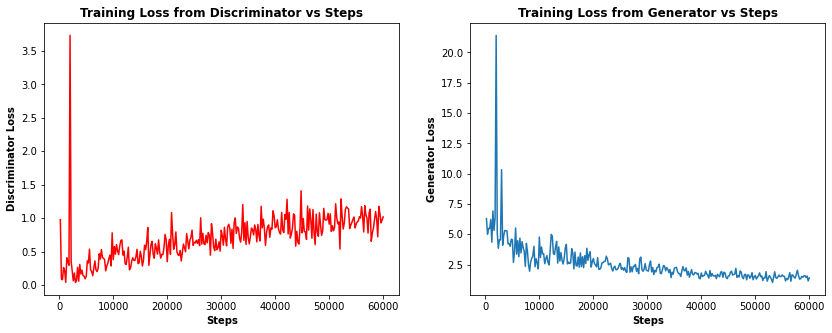

In [11]:
fig, axs = plt.subplots(1, 2, figsize =(14,5))
axs[0].plot(count_step_list, d_loss_list, '-r' )
axs[0].set_title("Training Loss from Discriminator vs Steps", fontweight='bold')
axs[0].set_xlabel("Steps", fontweight='bold')
axs[0].set_ylabel("Discriminator Loss", fontweight='bold')

axs[1].plot(count_step_list, g_loss_list )
axs[1].set_title("Training Loss from Generator vs Steps", fontweight='bold')
axs[1].set_xlabel("Steps", fontweight='bold')
axs[1].set_ylabel("Generator Loss", fontweight='bold')

plt.savefig('Loss.png')
plt.show()

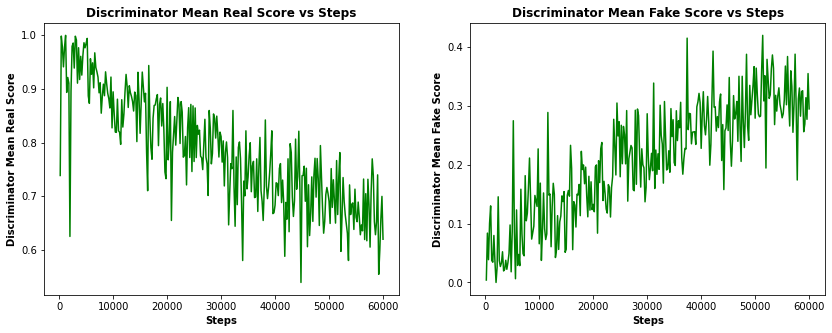

In [12]:
fig, axs = plt.subplots(1, 2, figsize =(14,5))
axs[0].plot(count_step_list, realscore_list, '-g' )
axs[0].set_title("Discriminator Mean Real Score vs Steps", fontweight='bold')
axs[0].set_xlabel("Steps", fontweight='bold')
axs[0].set_ylabel("Discriminator Mean Real Score", fontweight='bold')

axs[1].plot(count_step_list, fakescore_list, '-g' )
axs[1].set_title("Discriminator Mean Fake Score vs Steps", fontweight='bold')
axs[1].set_xlabel("Steps", fontweight='bold')
axs[1].set_ylabel("Discriminator Mean Fake Score", fontweight='bold')
plt.savefig('Score.png')
plt.show()